In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
data_feng_2013 = np.genfromtxt('Precon1470-1999_ci_tseries.csv', delimiter=",", dtype=float) # ismr reconstruction
yy = data_feng_2013[:,0]
pr = data_feng_2013[:,1]

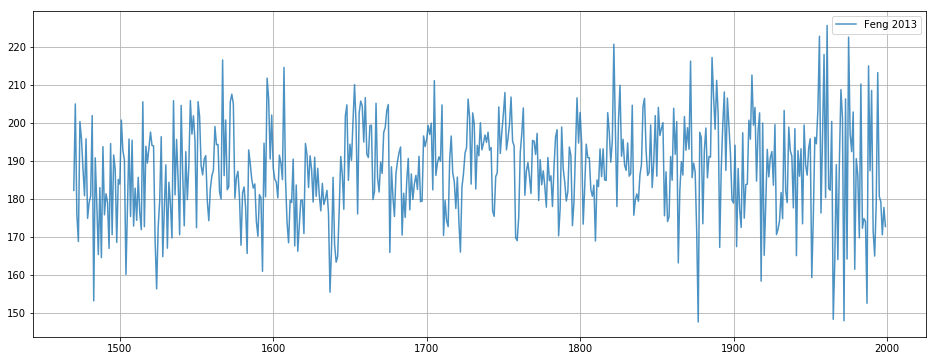

In [3]:
plt.figure(figsize=(16,6))
plt.plot(yy, pr, label='Feng 2013', alpha=0.8)
plt.legend()
plt.grid()

In [11]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 100# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


In [12]:
ismr_feng_ssa = ssa(pr)

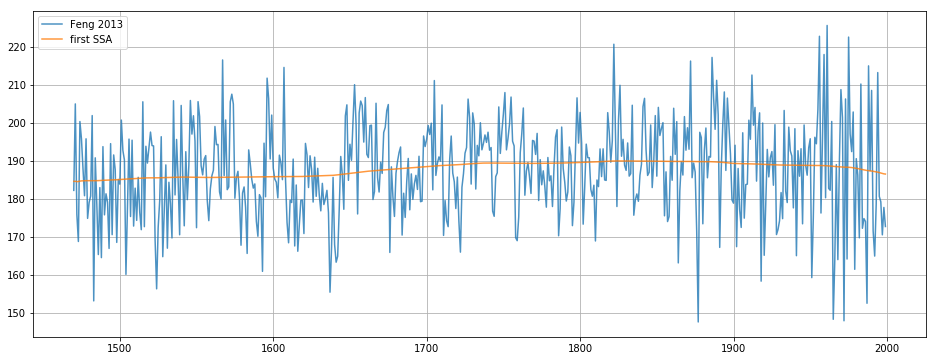

In [13]:
plt.figure(figsize=(16,6))
plt.plot(yy, pr, label='Feng 2013', alpha=0.8)
plt.plot(yy, ismr_feng_ssa[0], label='first SSA', alpha=0.8)
plt.legend()
plt.grid()

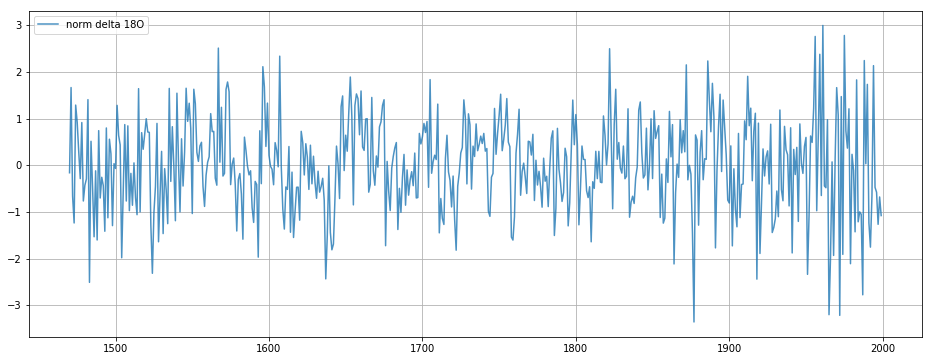

In [14]:
ismr_feng_ssa_anom = pr-ismr_feng_ssa[0]
ismr_feng_ssa_anom_norm  = (ismr_feng_ssa_anom - np.mean(ismr_feng_ssa_anom))/(np.std(ismr_feng_ssa_anom))
plt.figure(figsize=(16,6))
plt.plot(yy, ismr_feng_ssa_anom_norm, label='norm delta 18O', alpha=0.8)
plt.legend()
plt.grid()

In [15]:
ismr_feng_2013_anom_yy = np.zeros((ismr_feng_ssa_anom_norm.shape[0],2))
ismr_feng_2013_anom_yy[:,0] = yy[:]
ismr_feng_2013_anom_yy[:,1] = ismr_feng_ssa_anom_norm[:]
np.savetxt('ismr_feng_2013_anom_yy.txt', ismr_feng_2013_anom_yy, delimiter=",")